# Capstone Two - 4 Pre-Processing and ARIMA Model<a id='4'></a>

## 4.1 Contents<a id='4.1'></a>
* [4 Pre-Processing and ARIMA model](#4)
  * [4.1 Contents](#4.1)
  * [4.2 Imports](#4.2)
  * [4.3 Load The Data](#4.3)
  * [4.4 Processing Categorical Variables](#4.4)
  * [4.5 Processing Sales Data](#4.5)
  * [4.6 Time Series Components](#4.6)
    * [4.6.1 Decomposition](#4.6.1)
    * [4.6.2 Stationarity testing](#4.6.2)
  * [4.7 The ARIMA Model](#4.7) 
    * [4.7.1 Make a function to find the MSE of a single ARIMA model](#4.7.1)
    * [4.7.2 Make a function to evaluate the different ARIMA models with different p, d, and q values](#4.7.2)
    * [4.7.3 Visualize model results](#4.7.3)
    * [4.7.4 Application: Forecasting](#4.7.4)
    

## 4.2 Imports<a id='4.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# kpss for stationary test
from statsmodels.tsa.stattools import kpss

# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from library.sb_utils import save_file

## 4.3 Load The Data<a id='4.3'></a>

In [2]:
data_dir = '../data/'

# Grocery sales at store No.44
data = pd.read_csv(data_dir+'train_selected_group.csv')

In [3]:
data.head(8)

,date,sales,onpromotion,dcoilwtico,transactions,holiday_type,transferred,day_of_week,sales_lag1,sales_lag2,sales_lag3,sales_3_day_avg,sales_week_avg
0,2013-01-01,0.0,0.0,93.14,0.0,Holiday,False,Tuesday,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,10686.0,0.0,93.14,4821.0,Normal,False,Wednesday,0.0,NaN,NaN,NaN,NaN
2,2013-01-03,7342.0,0.0,92.97,3618.0,Normal,False,Thursday,10686.0,0.0,NaN,NaN,NaN
3,2013-01-04,7250.0,0.0,93.12,4169.0,Normal,False,Friday,7342.0,10686.0,0.0,6009.3,NaN
4,2013-01-05,10699.0,0.0,93.12,4921.0,Work Day,False,Saturday,7250.0,7342.0,10686.0,8426.0,NaN
5,2013-01-06,12373.0,0.0,93.12,4925.0,Normal,False,Sunday,10699.0,7250.0,7342.0,8430.3,NaN
6,2013-01-07,7059.0,0.0,93.20,3871.0,Normal,False,Monday,12373.0,10699.0,7250.0,10107.3,NaN
7,2013-01-08,19849.0,0.0,93.21,3593.0,Normal,False,Tuesday,7059.0,12373.0,10699.0,10043.7,7915.6


Note that on the first date "2013-01-01", the store was colsed so the sales was zero. And the first 7 rows of the "lag" columns were NaN.

## 4.4 Processing Categorical Features<a id='4.4'></a>

Create dummy or indicator features for categorical variables: day_of_week and holiday.

In [4]:
# Weekday or Weekend
data.loc[data['day_of_week'].isin(['Monday','Tuesday','Wednesday','Thursday','Friday']), 'day_of_week'] = 'Weekday'
data.loc[data['day_of_week'].isin(['Saturday','Sunday']), 'day_of_week'] = 'Weekend'

In [5]:
# Weekend but Workday -> Weekday
data.loc[data['holiday_type'] == 'Work Day', 'day_of_week'] = 'Weekday'

In [6]:
# Holiday or Non_holiday
data.loc[ (data['holiday_type'] == 'Holiday') & (data['transferred'] == True), 'holiday_type'] = 'Non_holiday'
data.loc[ data['holiday_type'].isin(['Additional','Bridge','Event','Transfer']), 'holiday_type'] = 'Holiday'
data.loc[ data['holiday_type'].isin(['Normal','Work Day']), 'holiday_type'] = 'Non_holiday'

In [7]:
dummy_hol = pd.get_dummies(data['holiday_type'])
dummy_hol.head()

,Holiday,Non_holiday
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [8]:
dummy_dow = pd.get_dummies(data['day_of_week'])
dummy_dow.head()

,Weekday,Weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [9]:
data = pd.concat([data, dummy_hol], axis=1)
data = pd.concat([data, dummy_dow], axis=1)

In [10]:
data.drop(['holiday_type', 'transferred', 'day_of_week'], axis=1, inplace=True)

In [11]:
data.head()

,date,sales,onpromotion,dcoilwtico,transactions,sales_lag1,sales_lag2,sales_lag3,sales_3_day_avg,sales_week_avg,Holiday,Non_holiday,Weekday,Weekend
0,2013-01-01,0.0,0.0,93.14,0.0,NaN,NaN,NaN,NaN,NaN,1,0,1,0
1,2013-01-02,10686.0,0.0,93.14,4821.0,0.0,NaN,NaN,NaN,NaN,0,1,1,0
2,2013-01-03,7342.0,0.0,92.97,3618.0,10686.0,0.0,NaN,NaN,NaN,0,1,1,0
3,2013-01-04,7250.0,0.0,93.12,4169.0,7342.0,10686.0,0.0,6009.3,NaN,0,1,1,0
4,2013-01-05,10699.0,0.0,93.12,4921.0,7250.0,7342.0,10686.0,8426.0,NaN,0,1,1,0


## 4.5 Processing Sales Data<a id='4.5'></a>

Let's type convert the `date` column to a Python datetime, before making that the index.

In [12]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

Making a predictor variable y:

In [13]:
y = data['sales']

In [14]:
# Drop "2013-01-01" value since it's zero.
y.drop(labels=['2013-01-01'], inplace=True)

In [15]:
type(y)

pandas.core.series.Series

Getting summary statistics for y:

In [16]:
y.describe()

count     1687.000000
mean      9760.911970
std       3537.978965
min       2990.000000
25%       7293.000000
50%       8809.000000
75%      11665.000000
max      46271.000000
Name: sales, dtype: float64

Plotting y:

<AxesSubplot:xlabel='date'>

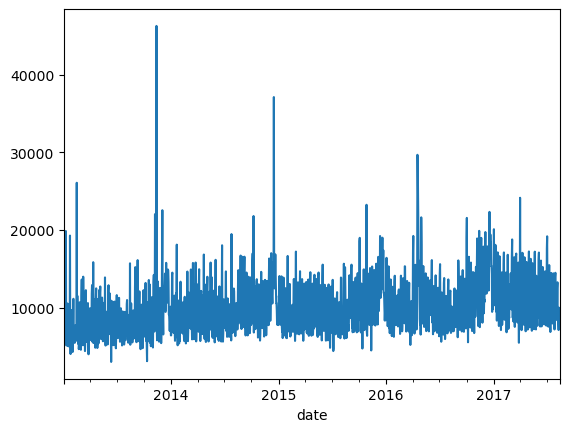

In [17]:
y.plot()

## 4.6 Time Series Components<a id='4.6'></a>

### 4.6.1 Decomposition<a id='4.6.1'></a>

we can use the decompose() function to quantify the component parts described above in our data.

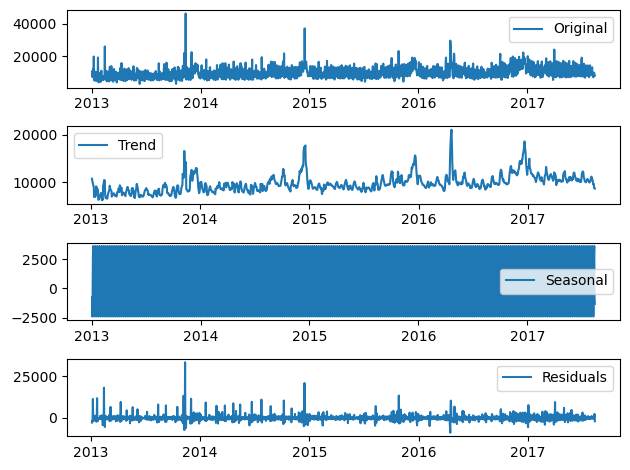

In [18]:
# Make a variable called decomposition, and assign it y passed to seasonal_decompose() 
decomposition = seasonal_decompose(y)

# Make three variables for trend, seasonal and residual components respectively. 
# Assign them the relevant features of decomposition 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = 'Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 4.6.2 Stationarity testing<a id='4.6.2'></a>

Testing for stationarity with KPSS:

In [19]:
# Use kpss()
kpss(y)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(4.484627548650581,
 0.01,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Since our p-value is less than 0.01, we should reject the Null hypothesis and deduce the non-stationarity of our data.

But our data need to be stationary! So we need to do some transforming.

**Making the data stationary:**

In [20]:
# Declare a variable called y_log
y_log = np.log(y)

<AxesSubplot:xlabel='date'>

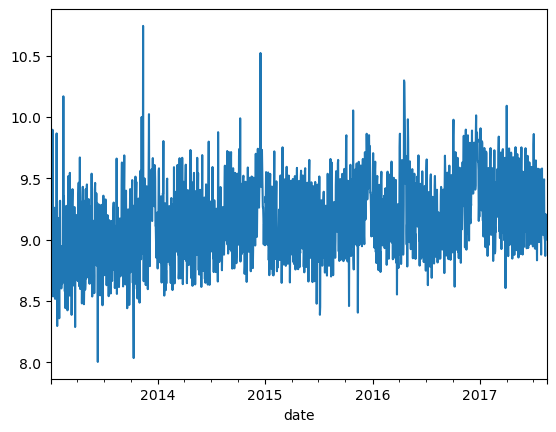

In [21]:
y_log.plot()

We can try to make this time series stationary by differencing our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

We can use the diff() function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [22]:
kpss(y_log.diff().dropna())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.04091697403043888,
 0.1,
 55,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.1, so we can accept the null hypothesis that our data is **stationary**.

## 4.7 The ARIMA Model<a id='4.7'></a>

### 4.7.1 Make a function to find the MSE of a single ARIMA model<a id='4.7.1'></a>

ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

**Train-Test Split:** Since the forecasting horizon is 16 days, we also set the testing set to 16 days. 

In [23]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=1687-16 #int(len(data) * 0.8) #
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

### 4.7.2 Make a function to evaluate the different ARIMA models with different p, d, and q values<a id='4.7.2'></a>

In [24]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.12f' % (best_cfg, best_score))

In [25]:
# Now, we choose a couple of values to try for each parameter: p_values, d_values and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [26]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!
import warnings
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.027832619468
ARIMA(0, 0, 1) MSE=0.022935433181
ARIMA(0, 0, 2) MSE=0.023359770164
ARIMA(0, 1, 0) MSE=0.043288075907
ARIMA(0, 1, 1) MSE=0.031826500254
ARIMA(0, 1, 2) MSE=0.027177098604
ARIMA(0, 2, 0) MSE=0.100972667999
ARIMA(0, 2, 1) MSE=0.043314621348
ARIMA(0, 2, 2) MSE=0.032125274598
ARIMA(1, 0, 0) MSE=0.024827667405
ARIMA(1, 0, 1) MSE=0.023344458126
ARIMA(1, 0, 2) MSE=0.023424507995
ARIMA(1, 1, 0) MSE=0.042106200457
ARIMA(1, 1, 1) MSE=0.029208585077
ARIMA(1, 1, 2) MSE=0.026940493106
ARIMA(1, 2, 0) MSE=0.090746455967
ARIMA(1, 2, 1) MSE=0.042136834934
ARIMA(1, 2, 2) MSE=0.043291045420
ARIMA(2, 0, 0) MSE=0.024112725129
ARIMA(2, 0, 1) MSE=0.023340028969
ARIMA(2, 0, 2) MSE=0.025375749847
ARIMA(2, 1, 0) MSE=0.032417945656
ARIMA(2, 1, 1) MSE=0.027456753684
ARIMA(2, 1, 2) MSE=0.029142878248
ARIMA(2, 2, 0) MSE=0.069380213508
ARIMA(2, 2, 1) MSE=0.032452031507
ARIMA(2, 2, 2) MSE=0.027674029121
Best ARIMA(0, 0, 1) MSE=0.022935433181


So the best p,d, q, parameters for our ARIMA model are 0, 0, 1 respectively. Now we know this, we can build the model.

In [29]:
p,d,q = (0,0,1)
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()

In [30]:
# Call summary() on model_fit
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1687
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -306.786
Date:                Thu, 18 May 2023   AIC                            619.571
Time:                        09:23:22   BIC                            635.864
Sample:                    01-02-2013   HQIC                           625.605
                         - 08-15-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.1304      0.011    832.604      0.000       9.109       9.152
ma.L1          0.4890      0.018     27.257      0.000       0.454       0.524
sigma2         0.0842      0.002     33.991      0.000       0.079       0.089
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):               101.48
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 4.7.3 Visualize model results<a id='4.7.3'></a>

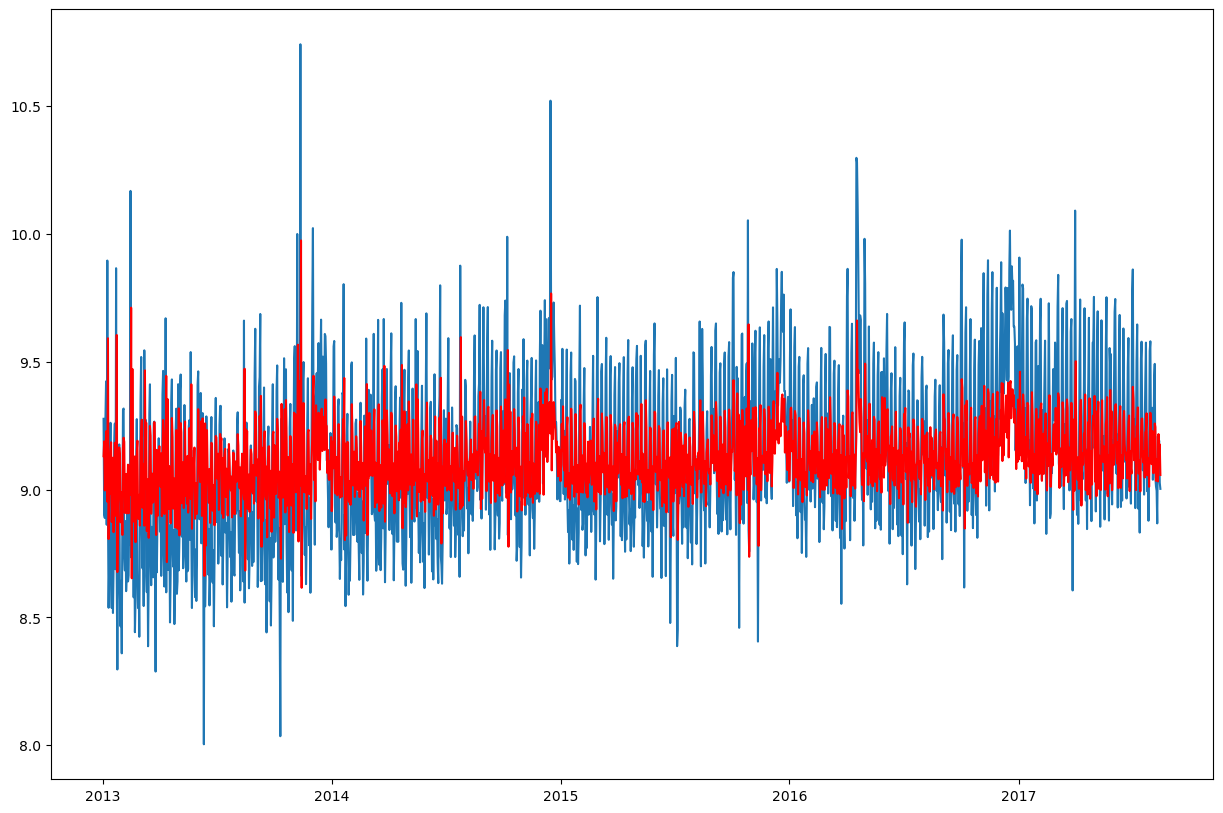

In [32]:
# Call figure() and plot() on the plt
plt.figure(figsize=(15,10))
#plt.plot(y_log.diff())
plt.plot(y_log)
plt.plot(model_fit.predict(), color = 'red')